In [5]:
# !pip install datasets fasttext evaluate
import os
import subprocess
import kagglehub
import pandas as pd
import numpy as np
from datasets import Dataset, DatasetDict, Features, Value, ClassLabel
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score, accuracy_score
from sklearn.feature_extraction.text import CountVectorizer
from imblearn.under_sampling import RandomUnderSampler
import spacy
import spacy.cli
import fasttext.util as fasttext_util
import fasttext
from collections import Counter
from torch.utils.data import DataLoader
import torch.nn as nn
import torch
import tqdm
import pickle
from transformers import AutoTokenizer, AutoModelForSequenceClassification, TrainingArguments, Trainer, EarlyStoppingCallback
import evaluate
import warnings
import sys
from tqdm import tqdm
import matplotlib.pyplot as plt
from importnb import Notebook
from tokenizer_helper_fns import custom_tokenizer
from model_architectures import BidirectionalGRUTextClassifier

device = torch.device("mps") if torch.backends.mps.is_available() else torch.device("cuda" if torch.cuda.is_available() else "cpu")
warnings.filterwarnings("ignore")

# Data

In [6]:
# DATA

DATA_DIR = "./data"
INFERENCE_DATA = "./data/inference_data.csv"

if os.path.exists(INFERENCE_DATA):
    print("Loading data")
    inference_df = pd.read_csv(INFERENCE_DATA)
else:
    os.makedirs(DATA_DIR, exist_ok=True)
    print("calling data proicessing script")
    
    # Calling the Jupyter notebook script
    subprocess.run(['jupyter', 'nbconvert', '--execute', '--to', 'notebook', '--inplace', '1_data_processing.ipynb'])

Loading data


# Transformer Inference

In [7]:
# TRANSFORMER INFERENCE ================================================================
model_path = "./models/transformer_results"
bert_tokenizer = AutoTokenizer.from_pretrained(model_path)
bert_uncased = AutoModelForSequenceClassification.from_pretrained(model_path)

if "text" not in inference_df:
    raise KeyError("The 'text' column is missing from inference_df.")

inference_df = inference_df[inference_df["text"].notna()]  # Drop rows with NaN
inference_df["text"] = inference_df["text"].astype(str)  # Ensure all are strings


# Tokenize climate tweets
CLIMATE_TOKENISED_BERT_DIR = './cache/climate_tokenised_bert.pkl'

if os.path.exists(CLIMATE_TOKENISED_BERT_DIR):
    print("Tokenized climate tweets pkl file found. Loading data...")
    with open(CLIMATE_TOKENISED_BERT_DIR, 'rb') as f:
        climate_tokenised_bert = pickle.load(f)
else:
    print("Pickle file not found. Tokenizing climate tweets...")
    climate_tokenised_bert = bert_tokenizer(
        list(inference_df["text"]),  
        truncation=True,
        padding="max_length",
        max_length=512,
        return_tensors="pt"
    )
    with open(CLIMATE_TOKENISED_BERT_DIR, 'wb') as f:
        pickle.dump(climate_tokenised_bert, f)
    print("Tokenized climate tweets and saved to file.")

# Predict using fine-tuned Transformer model
device = torch.device("mps") if torch.backends.mps.is_available() else torch.device("cpu")
print(f"Using device: {device}")

def predict_climate_tweets(model, tokenized_texts, batch_size=32, device='mps'):
    model.to(device)
    model.eval()

    predictions = []
    with torch.no_grad():
        for i in range(0, len(tokenized_texts['input_ids']), batch_size):
            batch_input_ids = tokenized_texts['input_ids'][i:i + batch_size].to(device)
            batch_attention_mask = tokenized_texts['attention_mask'][i:i + batch_size].to(device)

            outputs = model(input_ids=batch_input_ids, attention_mask=batch_attention_mask)
            preds = torch.nn.functional.softmax(outputs.logits, dim=-1)
            predicted_labels = torch.argmax(preds, dim=1)
            predictions.extend(predicted_labels.cpu().numpy())

    return predictions

predicted_labels_transformer = predict_climate_tweets(bert_uncased, climate_tokenised_bert, batch_size=32, device=device)

# predicted labels
inference_df['predicted_label_transformer'] = predicted_labels_transformer
inference_df['predicted_label_transformer'] = inference_df['predicted_label_transformer'].replace({0: 'factual', 1: 'misinformation'})

Pickle file not found. Tokenizing climate tweets...
Tokenized climate tweets and saved to file.
Using device: mps


Transformer Inference: Distribution of 'factual' vs 'misinformation' predictions:
predicted_label_transformer
misinformation    9952
factual           7538
Name: count, dtype: int64


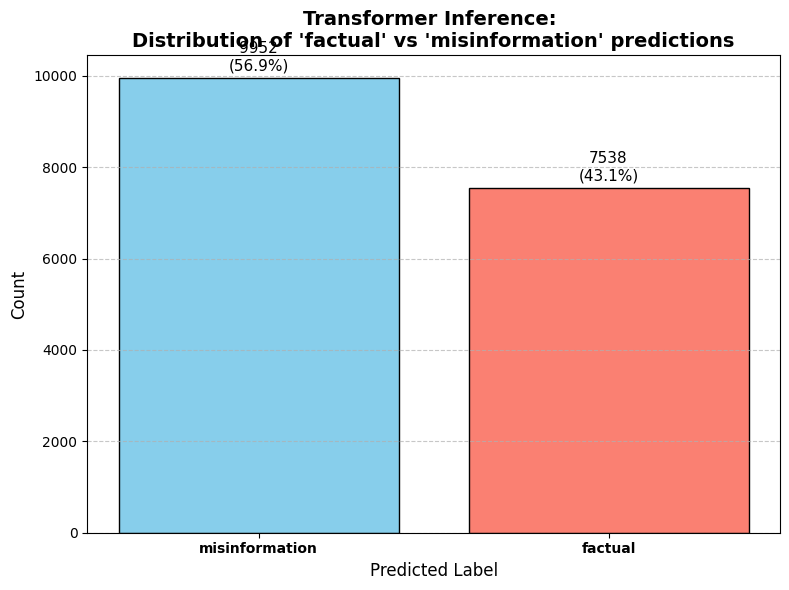

In [8]:
# Count occurrences of each label
label_counts = inference_df['predicted_label_transformer'].value_counts()

print("Transformer Inference: Distribution of 'factual' vs 'misinformation' predictions:")
print(label_counts)

total = label_counts.sum()
percentages = (label_counts / total) * 100

plt.figure(figsize=(8, 6))
bars = plt.bar(label_counts.index, label_counts.values, edgecolor='black', color=['skyblue', 'salmon'])
plt.title("Transformer Inference: \nDistribution of 'factual' vs 'misinformation' predictions", fontsize=14, weight='bold')
plt.ylabel('Count', fontsize=12)
plt.xlabel('Predicted Label', fontsize=12)
plt.xticks(fontsize=10, weight='bold')
plt.yticks(fontsize=10)
plt.grid(axis='y', linestyle='--', alpha=0.7)

# Add data labels with percentages on top of the bars
for bar, count, percentage in zip(bars, label_counts.values, percentages):
    plt.text(bar.get_x() + bar.get_width() / 2, bar.get_height() + total * 0.01,
             f"{count}\n({percentage:.1f}%)", ha='center', fontsize=11)

plt.tight_layout()
plt.show()


# Non-Transfomer Inference

In [9]:
# loading model & tokeniser -------

class BidirectionalGRUTextClassifier(nn.Module):
    def __init__(self, embedding_tensor):
        super().__init__()
        # 1) Embedding layer (frozen)
        self.embedding_layer = nn.Embedding.from_pretrained(
            embedding_tensor,
            freeze=True
        )
        
        # 2) 2-layer GRU with dropout + bidirection
        self.gru = nn.GRU(
            input_size=embedding_tensor.size(1),  # embedding dim
            hidden_size=64,
            num_layers=2,
            batch_first=True,
            dropout=0.5,       # dropout only applied between stacked layers
            bidirectional=True
        )
        
        # 3) Classification layer
        #    hidden_size=64 * 2 directions = 128
        self.classification_layer = nn.Linear(in_features=64 * 2, out_features=1)

    def forward(self, x, lengths):
        # x: [batch_size, seq_len]
        # lengths: [batch_size] (lengths of each sequence)

        # 1) Embedding
        x = self.embedding_layer(x)  
        # x now: [batch_size, seq_len, embedding_dim]

        # 2) Pack padded sequence for RNN
        x = nn.utils.rnn.pack_padded_sequence(
            x, 
            lengths.cpu().numpy(), 
            enforce_sorted=False, 
            batch_first=True
        )

        # 3) Forward pass through GRU
        #    - out is a PackedSequence
        #    - h is [num_layers * num_directions, batch_size, hidden_size]
        out, h = self.gru(x)
        
        # For a 2-layer bidirectional GRU:
        # h.shape = [4, batch_size, 64]
        # The top layer forward hidden is h[-2], backward is h[-1]
        forward_top = h[-2, :, :]    # shape: [batch_size, 64]
        backward_top = h[-1, :, :]   # shape: [batch_size, 64]

        # 4) Concatenate the final forward + backward states
        x = torch.cat([forward_top, backward_top], dim=1)  # [batch_size, 128]

        # 5) Classification
        #    (for binary classification, you typically pair with BCEWithLogitsLoss)
        x = self.classification_layer(x)  # [batch_size, 1]

        return x

TOP_MODEL_PATH = "./models/bidirectional_gru_model.pth"
RNN_BASED_MODEL = torch.load(TOP_MODEL_PATH)
RNN_BASED_MODEL.eval()

with open("./cache/rnn_tokenizer_file.pkl", "rb") as f:
    RNN_TOKENISER = pickle.load(f)

In [10]:
# load helper functions 

from tokenizer_helper_fns import batch_tokenize, custom_analyzer, vocab_mapping
from data_loader_helper_fns import collate_fn

# pipeline for GRU/RNNs etc ==========

TOKENIZER_FILEPATH = './cache/rnn_tokenizer_file.pkl'
INFERENCE_TOKENISED_FILEPATH = './cache/climate_tokenised_rnn.pkl'

if os.path.exists(INFERENCE_TOKENISED_FILEPATH):
    with open(INFERENCE_TOKENISED_FILEPATH, 'rb') as f:
        climate_tokenised_rnn = pickle.load(f)
    print(f"Tokenized climate tweets pkl file found. Loading data...")
else:    
    with open(TOKENIZER_FILEPATH, 'rb') as f:
        rnn_tokenizer = pickle.load(f)
        
    climate_tokenised_rnn = batch_tokenize(
        inference_df["text"],
        32,
        lambda text: custom_analyzer(text, trained_tokenizer=rnn_tokenizer)
    )

    # save tokenised text
    with open(INFERENCE_TOKENISED_FILEPATH, 'wb') as f:
        pickle.dump(climate_tokenised_rnn, f)

# VOCAB MAPPING ---------------------------------------------------------------------------------------------------

# use same vocab: loading vocab from training
with open("./cache/vocab_idx.pkl", "rb") as f:
    vocab_idx = pickle.load(f)

# CREATE DATALOADER ---------------------------------------------------------------------------------------------------

max_seq_length=300

def collate_inference_fn(data, vocab_idx, include_lengths=True):
    vocab_idx=vocab_idx
    text_list, label_list, lengths = [], [], []
    for _text in data:
        # Integer encoding with truncation
        processed_text = torch.tensor([vocab_idx[token] for token in _text][:max_seq_length],
                                      dtype=torch.int64)
        text_list.append(processed_text)
        lengths.append(processed_text.size(0))
    label_list = torch.tensor(label_list)
    lengths = torch.tensor(lengths)
    # Padding
    padded_text_list = nn.utils.rnn.pad_sequence(text_list,
                                                 batch_first=True,
                                                 padding_value=0)
    if include_lengths:
        return padded_text_list, lengths
    else:
        return padded_text_list,
    
inference_dl = DataLoader(
    dataset=list(climate_tokenised_rnn),
    batch_size=32, 
    shuffle=False, 
    collate_fn=lambda x: collate_inference_fn(
        x, 
        include_lengths=True,
        vocab_idx=vocab_idx  
    )
)

# ADD EMBEDDINGS ---------------------------------------------------------------------------------------------------
# reuse same embedding tensor and mapping; already loaded into the model architecture at first layer

Tokenizing batch 200 of 547...
Tokenizing batch 400 of 547...
Tokenizing batch 547 of 547...


In [11]:
def gru_inference(model, dataloader, use_lengths=True):
    model = model.to(device)
    model.eval()
    predictions = []

    # Inference loop
    with torch.no_grad():
        for batch in tqdm(dataloader, desc="Evaluating", leave=False):
            if use_lengths:
                x_batch, lengths = batch
                x_batch, lengths = x_batch.to(device), lengths.to(device)
                logits = model(x_batch, lengths)
            else:
                x_batch = batch
                x_batch = x_batch.to(device)
                logits = model(x_batch)

            
            probs = torch.sigmoid(logits)        # [batch_size, 1], in [0,1]
            predicted_labels = (probs >= 0.5).long()             
            predictions.extend(predicted_labels.cpu().numpy())  # Move to CPU and convert to NumPy

    return predictions

# inference
device = torch.device("mps") if torch.backends.mps.is_available() else torch.device("cpu")

predicted_labels_gru = gru_inference(RNN_BASED_MODEL, inference_dl, use_lengths=True)

inference_df['predicted_label_gru'] = predicted_labels_gru
inference_df['predicted_label_gru'] = inference_df['predicted_label_gru'].replace({0: 'factual', 1: 'misinformation'})

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


GRU inference: Distribution of 'factual' vs 'misinformation' predictions:
predicted_label_gru
factual           9162
misinformation    8328
Name: count, dtype: int64


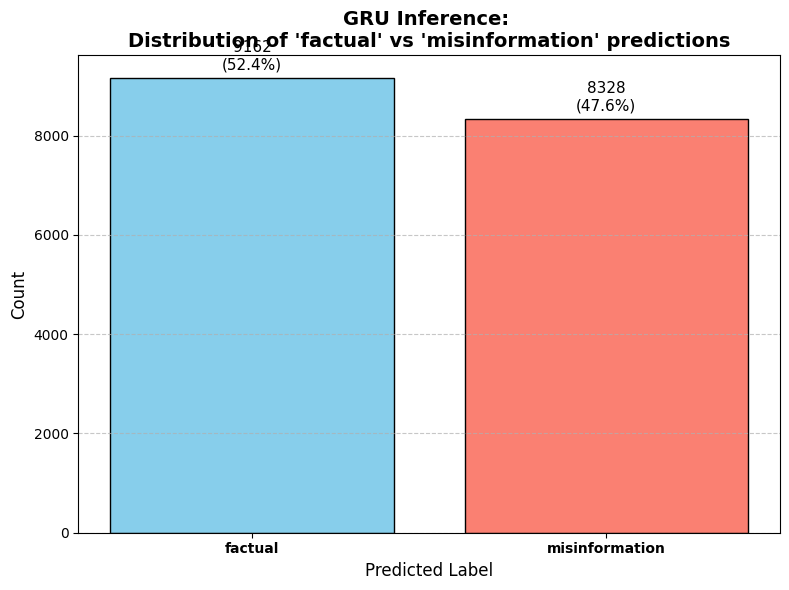

In [12]:
# Count occurrences of each label
label_counts = inference_df['predicted_label_gru'].value_counts()

print("GRU inference: Distribution of 'factual' vs 'misinformation' predictions:")
print(label_counts)

total = label_counts.sum()
percentages = (label_counts / total) * 100

plt.figure(figsize=(8, 6))
bars = plt.bar(label_counts.index, label_counts.values, edgecolor='black', color=['skyblue', 'salmon'])
plt.title("GRU Inference: \nDistribution of 'factual' vs 'misinformation' predictions", fontsize=14, weight='bold')
plt.ylabel('Count', fontsize=12)
plt.xlabel('Predicted Label', fontsize=12)
plt.xticks(fontsize=10, weight='bold')
plt.yticks(fontsize=10)
plt.grid(axis='y', linestyle='--', alpha=0.7)

# Add data labels with percentages on top of the bars
for bar, count, percentage in zip(bars, label_counts.values, percentages):
    plt.text(bar.get_x() + bar.get_width() / 2, bar.get_height() + total * 0.01,
             f"{count}\n({percentage:.1f}%)", ha='center', fontsize=11)

plt.tight_layout()
plt.show()

In [13]:
# print predictions from both models

output_path_inference = "/Users/henrybaker/Documents/repositories/nlp/nlp_research_note/data/climate_predictions.csv"

inference_df.to_csv("./data/climate_predictions.csv", index=False) 
    
print(f"Predictions saved to {output_path_inference}.")

Predictions saved to /Users/henrybaker/Documents/repositories/nlp/nlp_research_note/data/climate_predictions.csv.
